# Q2B Hackathon 2024

## Track 1 Hackathon Prompt

---

### Overview:

Last year, researchers began exploring problems that are difficult to simulate with brute-force classical methods, thanks to utility-scale quantum computers available on IBM Quantum™ Platform. But those experiments required a deep understanding of not just the quantum processing unit (QPU), but also the various error suppression and mitigation methods required to scale each individual problem.

Now, as we embark on a mission to make utility more accessible, we’re launching a platform called the **Qiskit Functions Catalog**. Using the Qiskit Functions Catalog, developers can release Qiskit Functions that unlock those capabilities for enterprise developers and quantum computational scientists.

---

### Your Goal:

The Track 1 Hackathon is about creating a business use case proposal that is built on a feature of the Qiskit Functions or Qiskit addons. You may choose to use an existing feature or create a new function to build your use case on. No matter what, your proposal must include real code as much as possible.

This hackathon prompt is aimed at the near future: 1-2 years from now. After all, Qiskit Functions exist today and are already being used by industry professionals and researchers. Please do not create a business use case around aspects of quantum computing that are further in the future than 1-2 years (i.e., fault-tolerant devices, undiscovered algorithms, etc.).

You will present your business use case to a panel of judges. The presentation is a graded part of your overall project score, so prepare accordingly.

---

### Project Requirements:

Your business use case must include at least 3 of the following, but in general, the more you are able to include, the better your team will score:

- A clear and well-detailed business use case
- Real Qiskit code snippets or examples
- Direct references to existing Qiskit functions or addons
- Consideration for devices currently on the market, both from IBM Quantum and others
- Thoughts on the market or types of customers
- Thoughts on what type of work or research your use case would empower
- Details about current limitations
- Case studies or business reports which reinforce your use case
- Roadblocks encountered while putting this use case together, and how your team overcame them

---

### Judging Criteria

#### **Technical Aspects (30 total points):**
- How well implemented is the Qiskit Function or Qiskit addon being discussed?
- Is it new and novel?
- Can the architecture serve users at a reasonable scale?
- How accessible is the end-user application? Is it easy to use and intuitive for end users?

#### **Business Aspects (25 total points):**
- Does the use case include market fit, target audience, and business goals?
- Does it properly introduce the use case and explain the interaction between business and user?

#### **Usefulness and Complexity (25 total points):**
- How useful is the project and how well-designed is it?
- Can it be used in real-world business applications or serve as a valuable tool for individuals?
- Are there ways this project could be further built out and refined upon?

#### **Presentation (20 total points):**
- How well did the team present their project?
- Were they able to explain their decisions?
- Did the entire team have a chance to speak?
- Did they tell a cohesive story?
- Does the business use case make sense when presented?

# Quantum Search on a Semantic Hilbert Space
**Team F**  
Joy Hwang Woodworth, Alex Vargas, Khouloud Alkhammassi

Install dependencies

In [1]:
# # First time downloads
# %pip install huggingface_hub
# %pip install datasets
# %pip install nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [2]:
import re
from datasets import load_dataset
from IPython.display import display, Latex
from datetime import datetime
from shss import SHS, SHS_Search_Custom, SHS_Search_Native, Corpus, SemanticHilbertSpace, SHSQuery, SemanticHilbertSpaceSearchCustom, SemanticHilbertSpaceSearchNative
from shss.semnet import *
from shss.utils import *

## 1. Load Data
### Load corpus dataset

In [3]:
DATASET = load_dataset('community-datasets/generics_kb', 'generics_kb_best')

### Load semnet

In [4]:
semnet = meta_semnet()

Semnet size: 171580
Converted semnet size: 75533
Semnet size: 423249
Converted semnet size: 383095
Semnet created with 440095 words


In [5]:
# semnet sample for reference
semnet_mini = { k:v for k,v in list(semnet.items())[110000:110005] }
print(semnet_mini)

{('dorymenia', 'n'): {'shell', 'worm', 'mollusk'}, ('dorymetaecus', 'n'): {'island', 'spider'}, ('dorymyrmex', 'n'): {'ant', 'cone', 'subfamily'}, ('doryonychus', 'n'): {'long', 'island'}, ('doryopteris', 'n'): {'tropical', 'family', 'fern'}}


***

## 2. Process dataset

### Filter dataset and extract random sample

In [22]:
# Filter for quality and length
filtered = DATASET.filter( lambda row: row['score'] > 0.9 and len(row['generic_sentence']) <= 40 )

Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

In [27]:
# #### OPTIONAL FILTERS ####
# # Filter for specific word
word = 'park'
def contains(word, sentence):
    reg = '\\b' + word
    m = re.search(reg, sentence)
    return True if m else False
filtered = DATASET.filter(lambda row: contains(word, row['generic_sentence']))

# # Filter for sentence length
# filtered = DATASET.filter( lambda row: len(row['generic_sentence']) <= 100 )

Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

In [28]:
shuf = filtered.shuffle()
sample = shuf['train'][0:10]
sentences = sample['generic_sentence']

# Print randomly selected sentences
print('DID\tTEXT')
for i,s in enumerate(sentences):
    print(f'{i+1}\t{s}')

DID	TEXT
1	Relaxation is located in parks.
2	Most national parks have visitors.
3	Many state parks have one or more small lakes on their property.
4	Play areas are located in parks.
5	Social problems add to risk for parks.
6	A car park is a lot
7	Many recreational parks offer golf, hiking, and a variety of individual and team sports.
8	Some bees live in parks.
9	Power steering is slow to react to quick inputs while parking.
10	Cities see parks as free land which has no value.


### Process sample
#### Convert sample to corpus data structure

In [29]:
corpus = Corpus(sentences, semnet)

#### Create Semantic Hilbert Space
Construct a Semantic Hilber Space (SHS) based on words in the corpus.

In [30]:
shs = SemanticHilbertSpace(corpus, semnet)
ts = datetime.now().strftime('%m_%d_%H%M%S')
save_shs_data(sentences, corpus, shs, ts)   # writes SHS corpus to file

***

## 3. Experiment: Query SHS Corpus for Word

### Construct queries

In [42]:
target_word = 'golf'
target_query = SHSQuery(target_word, shs, semnet)
print(f'Query "{target_query.query}" consists of sememes {target_query.sememes} with target vector {target_query.state}')

Query "golf" consists of sememes {'play', 'stroke', 'game'} with target vector {145, 269, 119}


### Create Semantic Hilbert Space Search (SHSS) Circuits

In [43]:
# QUERY
shss = SemanticHilbertSpaceSearchCustom(shs.num_sememes)
shss.set_query(shs.corpus, target_query.state)

Sample circuit for query


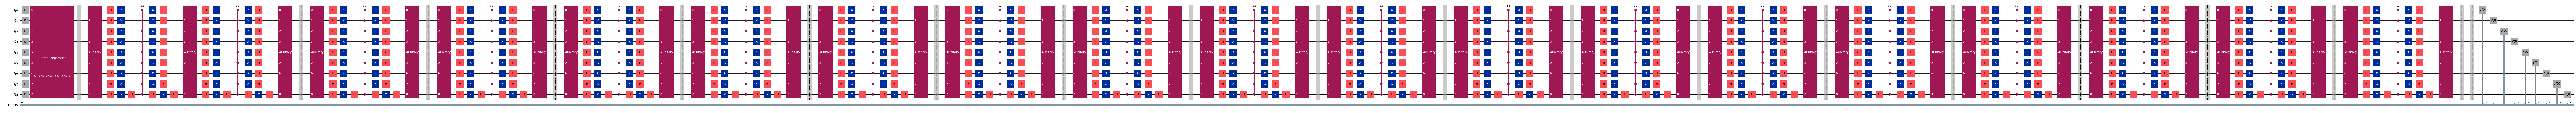

In [44]:
print('Sample circuit for query')
shss.circuits[0].decompose().draw(fold=1)

### Run program

In [45]:
SHOTS = 1000
results_custom = shss.run(shots=SHOTS, backend='qasm_simulator')

Backend: qasm_simulator | Num qubits: 9 | Num iterations: 17
DOCUMENT 1: transpiling circuit
DOCUMENT 1: running simulation
DOCUMENT 2: transpiling circuit
DOCUMENT 2: running simulation
DOCUMENT 3: transpiling circuit
DOCUMENT 3: running simulation
DOCUMENT 4: transpiling circuit
DOCUMENT 4: running simulation
DOCUMENT 5: transpiling circuit
DOCUMENT 5: running simulation
DOCUMENT 6: transpiling circuit
DOCUMENT 6: running simulation
DOCUMENT 7: transpiling circuit
DOCUMENT 7: running simulation
DOCUMENT 8: transpiling circuit
DOCUMENT 8: running simulation
DOCUMENT 9: transpiling circuit
DOCUMENT 9: running simulation
DOCUMENT 10: transpiling circuit
DOCUMENT 10: running simulation


#### Print Results

In [46]:
print(f'Expected results for query "{target_query.query}":\n')
print_expected(shs.corpus, target_query.state)

print(f'\nExperiment results for custom gates - query "{target_query.query}":\n')
dc = get_decimal_counts(results_custom)
answers = get_answers(dc, SHOTS, len(target_query.state))
print_answers(answers)

Expected results for query "golf":

DID    MATCHES
1      145, 119
2      145, 119
3      145, 119
4      145, 119
5      145, 119
6      145, 119
7      145, 269, 119
8      145, 119
9      145
10     145, 119

Experiment results for custom gates - query "golf":

DOC 1:  [58, 237, 133, 134, 240]
DOC 2:  [140, 119, 39, 30, 32, 142, 31, 82, 134, 137, 108, 29, 232, 136]
DOC 3:  []
DOC 4:  []
DOC 5:  [244, 243, 140, 136, 145]
DOC 6:  [66, 68]
DOC 7:  [137]
DOC 8:  [134, 226, 22, 228, 229, 106, 116, 227, 141, 144, 24, 139, 132, 131, 145, 20, 27, 21, 142, 136]
DOC 9:  [155, 189, 32, 130, 19]
DOC 10:  []


In [53]:
NUM_COUNTS = 10		# show top x hits
plot_exp_counts(dec_counts=dc, top_num=NUM_COUNTS)

***

# 4. Experiment on Qiskit Native Gates
## Implement QSA without custom unitary gates

Sample circuit for sememe query


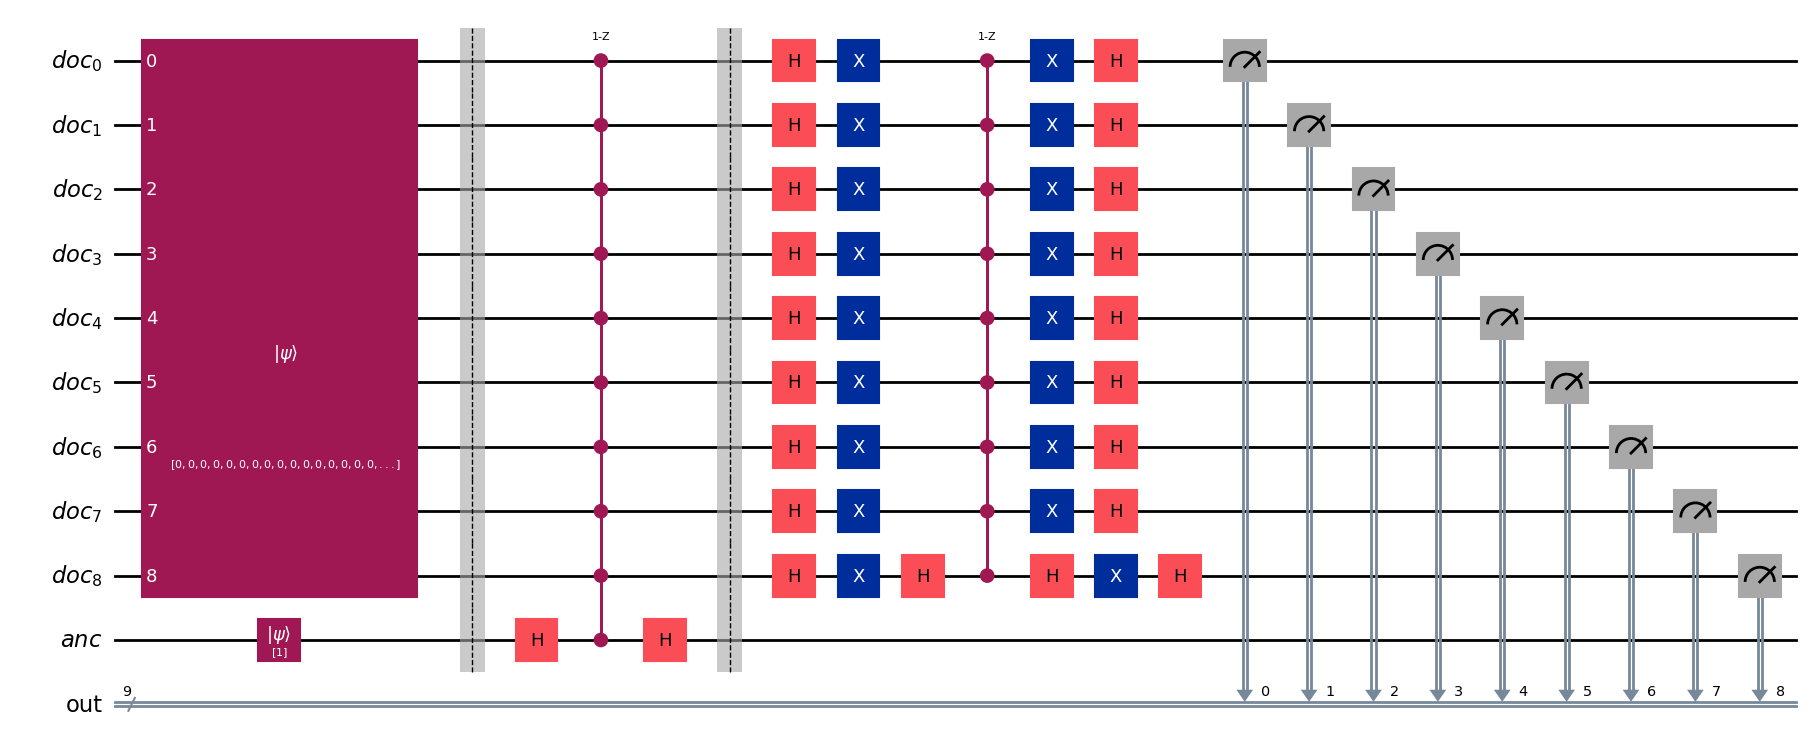

In [54]:
shss_native = SemanticHilbertSpaceSearchNative(shs.num_sememes)
shss_native.set_query(shs.corpus, target_query.state)
print('Sample circuit for sememe query')
shss_native.circuits[0].draw(fold=1)

In [55]:
results_native = shss_native.run(shots=SHOTS, backend='qasm_simulator')

Backend: qasm_simulator | Num qubits: 9
DOCUMENT 1: transpiling circuit
DOCUMENT 1: running simulation
DOCUMENT 2: transpiling circuit
DOCUMENT 2: running simulation
DOCUMENT 3: transpiling circuit
DOCUMENT 3: running simulation
DOCUMENT 4: transpiling circuit
DOCUMENT 4: running simulation
DOCUMENT 5: transpiling circuit
DOCUMENT 5: running simulation
DOCUMENT 6: transpiling circuit
DOCUMENT 6: running simulation
DOCUMENT 7: transpiling circuit
DOCUMENT 7: running simulation
DOCUMENT 8: transpiling circuit
DOCUMENT 8: running simulation
DOCUMENT 9: transpiling circuit
DOCUMENT 9: running simulation
DOCUMENT 10: transpiling circuit
DOCUMENT 10: running simulation


In [56]:
print(f'Expected results for query "{target_query.query}":\n')
print_expected(shs.corpus, target_query.state)

print(f'\nExperiment results for native gates - query "{target_query.query}":\n')
dc = get_decimal_counts(results_native)
answers = get_answers_top(dc, SHOTS)
print_answers(answers)

Expected results for query "golf":

DID    MATCHES
1      145, 119
2      145, 119
3      145, 119
4      145, 119
5      145, 119
6      145, 119
7      145, 269, 119
8      145, 119
9      145
10     145, 119

Experiment results for native gates - query "golf":

DOC 1:  {60, 133}
DOC 2:  {138}
DOC 3:  {28}
DOC 4:  {96}
DOC 5:  {68}
DOC 6:  {211}
DOC 7:  {113, 132}
DOC 8:  {23}
DOC 9:  {0, 1, 19}
DOC 10:  {176}


In [58]:
plot_exp_counts(dec_counts=dc, top_num=NUM_COUNTS)

# 5. Experiment on Cloud Compute Resources

#### Run on IonQ Cloud Simulator

In [75]:
# results = shss.run(shots=SHOTS, backend='ionq_simulator')

In [76]:
# dc = get_decimal_counts(results)
# answers  = get_answers_top(dc, SHOTS)
# print_answers(answers)
# plot_exp_counts(dec_counts=dc, top_num=NUM_COUNTS, answers=answers)